<div style="text-align: justify">
<font size=6><br><h2 align="center">Detección de las conductas distractoras al conducir un automóvil </h2></font>
<font size=5><br>
<h3 align="center">Inteligencia Artificial II</h3></font><font size=5>
<h3 align="center">Proyecto Final</h3></font> 
    
<br/>

<font size=5><h4 align="left">Intregrantes: </h4></font>      
2172016 - Kevin Javier Lozano Galvis<br><br>
2170688 - Brayan Rodolfo Barajas Ochoa<br>

# Librerias

In [4]:
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd 
import seaborn as sns
import tensorflow as tf
from skimage import color
import matplotlib.pyplot as plt
from dask.array.image import imread
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [5]:
!pip install --upgrade --force-reinstall --no-deps kaggle

Processing /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10/kaggle-1.5.10-cp37-none-any.whl
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kevinlozanogalvis","key":"7aa893581a3e3a99473c2eda021232eb"}'}

In [7]:
!ls -lha kaggle.json
!mkdir -p ~/.kaggle/
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 73 Mar 10 01:30 kaggle.json


In [8]:
!pip install -q kaggle

In [9]:
!kaggle competitions download -c state-farm-distracted-driver-detection -p imgs

100% 3.99G/4.00G [01:15<00:00, 21.6MB/s]
100% 4.00G/4.00G [01:15<00:00, 56.9MB/s]


In [10]:
cd imgs

/content/imgs


In [11]:
!unzip state-farm-distracted-driver-detection.zip -d /content

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/imgs/train/c7/img_56636.jpg  
  inflating: /content/imgs/train/c7/img_56661.jpg  
  inflating: /content/imgs/train/c7/img_56699.jpg  
  inflating: /content/imgs/train/c7/img_56717.jpg  
  inflating: /content/imgs/train/c7/img_56724.jpg  
  inflating: /content/imgs/train/c7/img_56768.jpg  
  inflating: /content/imgs/train/c7/img_56779.jpg  
  inflating: /content/imgs/train/c7/img_56849.jpg  
  inflating: /content/imgs/train/c7/img_56899.jpg  
  inflating: /content/imgs/train/c7/img_56938.jpg  
  inflating: /content/imgs/train/c7/img_5706.jpg  
  inflating: /content/imgs/train/c7/img_57076.jpg  
  inflating: /content/imgs/train/c7/img_57122.jpg  
  inflating: /content/imgs/train/c7/img_57137.jpg  
  inflating: /content/imgs/train/c7/img_5715.jpg  
  inflating: /content/imgs/train/c7/img_57278.jpg  
  inflating: /content/imgs/train/c7/img_57321.jpg  
  inflating: /content/imgs/train/c7/img_57345.jpg  
  inf

In [12]:
%pwd

'/content/imgs'

In [13]:
!rm state-farm-distracted-driver-detection.zip

In [14]:
%ls /content

driver_imgs_list.csv  imgs/  kaggle.json  sample_data/  sample_submission.csv


In [15]:
df = pd.read_csv("../driver_imgs_list.csv")
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


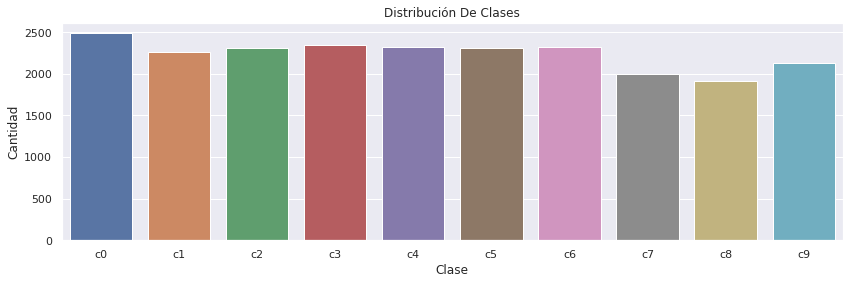

In [ ]:
sns.set()
plt.figure(figsize = (14,4))
sns.countplot(x = 'classname',data = df)
plt.title('Distribución de Clases'.title())
plt.xlabel('Clase')
plt.ylabel('Cantidad')

plt.show()

In [16]:
categor = {'c0': 'Safe driving', 
           'c1': 'Texting - right', 
           'c2': 'Talking on the phone - right', 
           'c3': 'Texting - left', 
           'c4': 'Talking on the phone - left', 
           'c5': 'Operating the radio', 
           'c6': 'Drinking', 
           'c7': 'Reaching behind', 
           'c8': 'Hair and makeup', 
           'c9': 'Talking to passenger'}

In [17]:
# Imágenes del dataset
f, ax = plt.subplots(1,3, figsize = (25,25))
for i in range(3):
    labels = imread("/content/imgs/train/c"+str(i)+"/*.jpg")
    for j in range(1):
        img = labels[j]
        label = i
        ax[i].axis('off')
        ax[i].imshow(img)
        ax[i].set_title(categor['c'+str(i)])
        plt.show

# Algunos ejemplos de como van a quedar las imágenes 
f, ax = plt.subplots(1,3, figsize = (40,40))
for i in range(3):
    labels = imread("/content/imgs/train/c"+str(i)+"/*.jpg")
    for j in range(1):
        img = labels[j]
        img = img[5:,100:-10]
        label = i
        ax[i].axis('off')
        ax[i].imshow(img)
        ax[i].set_title(categor['c'+str(i)])
        plt.show

Output hidden; open in https://colab.research.google.com to view.

# Procesamiento de Datos

In [18]:
driver_details = pd.read_csv('/content/driver_imgs_list.csv',na_values='na')
driver_details.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [19]:
train_image = []
image_label = []

for i in range(10):
    print('Class C',i)
    imgs = os.listdir("/content/imgs/train/c"+str(i))
    for j in range(len(imgs)):
        img_name = "/content/imgs/train/c"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img[5:,100:-10]
        img = cv2.resize(img,(128,128))
        label = i
        driver = driver_details[driver_details['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)

Class C 0
Class C 1
Class C 2
Class C 3
Class C 4
Class C 5
Class C 6
Class C 7
Class C 8
Class C 9


In [20]:
random.seed(10)
random.shuffle(train_image)

In [21]:
D = []
for features,labels,drivers in train_image:
    D.append(drivers)

In [22]:
deduped = []

for i in D:
    if i not in deduped:
        deduped.append(i)

In [23]:
driv_selected = []
driv_nums = random.sample(range(len(deduped)), 5)
for i in driv_nums:
    driv_selected.append(deduped[i])

In [24]:
X_train= []; y_train = []; X_test = []; y_test = []; D_train = []; D_test = []

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
        D_test.append(drivers)
    
    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)
    
print (len(X_train),len(X_test))
print (len(y_train),len(y_test))

17630 4794
17630 4794


In [25]:
X_train = np.array(X_train).reshape(-1,128,128,3)
X_test = np.array(X_test).reshape(-1,128,128,3)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

print (X_train.shape)

(17630, 128, 128, 3)


# Modelo Creado CNN 

In [ ]:
model_CNN = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), input_shape = (128 , 128 , 3), activation = 'relu',  kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Conv2D(64, (5,5) , activation = 'relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same'),
    tf.keras.layers.MaxPooling2D((3,3)),
    tf.keras.layers.Conv2D(128, (5,5) , activation = 'relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64 , activation = 'relu',kernel_initializer='he_uniform', bias_initializer='he_uniform'),
    tf.keras.layers.Dense(10, activation = 'softmax')])

In [ ]:
model_CNN.compile(loss = 'categorical_crossentropy' , optimizer = tf.keras.optimizers.SGD(lr = 0.001) , metrics = 'accuracy')
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       5

In [ ]:
history = model_CNN.fit(X_train , y_train, epochs = 20, batch_size=128, validation_data=(X_test, y_test)) 

Epoch 1/20
138/138 [==============================] - 37s 46ms/step - loss: 2.9336 - accuracy: 0.1293 - val_loss: 2.2465 - val_accuracy: 0.1696
Epoch 2/20
138/138 [==============================] - 6s 40ms/step - loss: 2.0613 - accuracy: 0.2777 - val_loss: 2.0938 - val_accuracy: 0.2728
Epoch 3/20
138/138 [==============================] - 6s 40ms/step - loss: 1.7253 - accuracy: 0.4027 - val_loss: 1.8454 - val_accuracy: 0.4080
Epoch 4/20
138/138 [==============================] - 6s 40ms/step - loss: 1.3907 - accuracy: 0.5315 - val_loss: 1.6341 - val_accuracy: 0.4624
Epoch 5/20
138/138 [==============================] - 6s 40ms/step - loss: 1.1131 - accuracy: 0.6351 - val_loss: 1.5256 - val_accuracy: 0.4857
Epoch 6/20
138/138 [==============================] - 6s 40ms/step - loss: 0.8731 - accuracy: 0.7207 - val_loss: 1.4307 - val_accuracy: 0.5403
Epoch 7/20
138/138 [==============================] - 6s 40ms/step - loss: 0.6939 - accuracy: 0.7842 - val_loss: 1.3807 - val_accuracy: 0.547

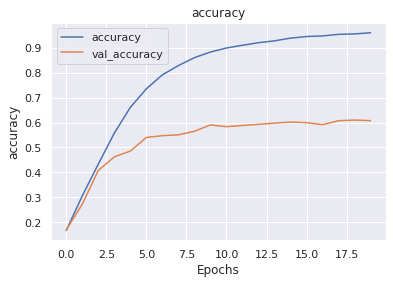

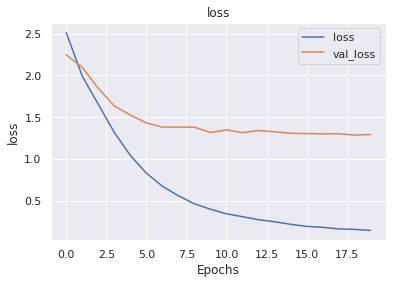

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title(string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Transfer Learning con VGG16 

In [ ]:
model_VGG16 =  tf.keras.applications.VGG16(include_top=False,input_shape=(128,128,3), weights='imagenet')
model_VGG16.trainable = True
print("Total layers of VGG16: ", len(model_VGG16.layers))

58892288/58889256 [==============================] - 1s 0us/step
Total layers of VGG16:  19


In [ ]:
for layer in model_VGG16.layers[:12]:
  layer.trainable =  False

model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [ ]:
model_cnn_VGG16 = tf.keras.models.Sequential([
    model_VGG16,
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(512, (1,1) , activation = 'relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_cnn_VGG16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 4, 512)         262656    
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 512)         2048      
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                8

In [ ]:
learning_rate= 0.0001
opt = tf.keras.optimizers.SGD(learning_rate)
model_cnn_VGG16.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_cnn_VGG16.fit(X_train, y_train , epochs=20,verbose=1, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/20
138/138 [==============================] - 28s 169ms/step - loss: 2.8918 - accuracy: 0.1121 - val_loss: 2.3348 - val_accuracy: 0.1346
Epoch 2/20
138/138 [==============================] - 18s 130ms/step - loss: 2.5526 - accuracy: 0.1445 - val_loss: 2.2351 - val_accuracy: 0.1692
Epoch 3/20
138/138 [==============================] - 18s 130ms/step - loss: 2.3592 - accuracy: 0.1858 - val_loss: 2.1190 - val_accuracy: 0.2440
Epoch 4/20
138/138 [==============================] - 18s 130ms/step - loss: 2.1917 - accuracy: 0.2301 - val_loss: 2.0078 - val_accuracy: 0.2895
Epoch 5/20
138/138 [==============================] - 18s 130ms/step - loss: 2.0120 - accuracy: 0.2908 - val_loss: 1.8861 - val_accuracy: 0.3474
Epoch 6/20
138/138 [==============================] - 18s 130ms/step - loss: 1.8493 - accuracy: 0.3601 - val_loss: 1.7643 - val_accuracy: 0.4215
Epoch 7/20
138/138 [==============================] - 18s 130ms/step - loss: 1.6722 - accuracy: 0.4196 - val_loss: 1.6463 - val_ac

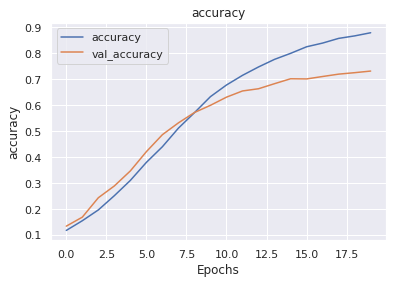

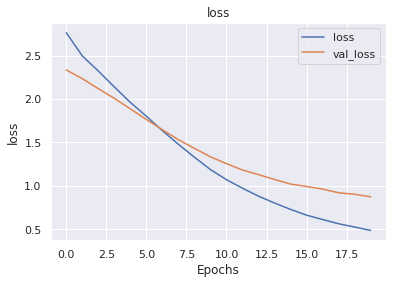

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title(string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
validation_loss, validation_acc = model_cnn_VGG16.evaluate(X_test, y_test, verbose = 1)

151/151 [==============================] - 5s 27ms/step - loss: 0.8734 - accuracy: 0.7319


# Transfer Learning VGG16 con Data Augmentation

In [32]:
datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.1, rotation_range=20)
datagen.fit(X_train)

In [33]:
training = datagen.flow(X_train, y_train, batch_size=128)

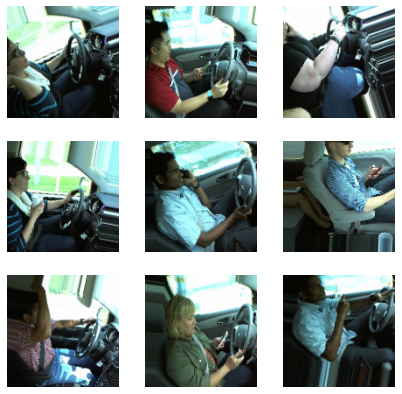

In [ ]:
plt.figure(figsize=(7,7));
plt.xticks([]);
plt.yticks([]);
plt.grid(False);

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(9):
      plt.subplot(330 + 1 + i)
      plt.imshow(X_batch[i].reshape(128, 128, 3), cmap=plt.cm.binary);
      plt.axis('off')
    plt.show()
    break

In [ ]:
model_VGG16_da =  tf.keras.applications.VGG16(include_top=False,input_shape=(128,128,3), weights='imagenet')
model_VGG16_da.trainable = True
print("Total layers of VGG16: ", len(model_VGG16_da.layers))

Total layers of VGG16:  19


In [ ]:
for layer in model_VGG16_da.layers[:12]:
  layer.trainable =  False

model_VGG16_da.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [ ]:
model_cnn_VGG16_da = tf.keras.models.Sequential([
    model_VGG16_da,
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(512, (1,1) , activation = 'relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_cnn_VGG16_da.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
dropout_11 (Dropout)         (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 512)         262656    
_________________________________________________________________
batch_normalization_3 (Batch (None, 4, 4, 512)         2048      
_________________________________________________________________
flatten_8 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)               

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('Models/model_VGG16.hdf5', verbose=1, save_best_only=True)
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [ ]:
learning_rate= 0.0004
opt = tf.keras.optimizers.SGD(learning_rate)
model_cnn_VGG16_da.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_cnn_VGG16_da.fit(training,  steps_per_epoch = len(X_train)/128, callbacks=[checkpointer, earlystopper], epochs = 20, verbose=1,validation_data=(X_test, y_test))

Epoch 1/20
137/137 [==============================] - 71s 506ms/step - loss: 3.2255 - accuracy: 0.1129 - val_loss: 2.1099 - val_accuracy: 0.2681

Epoch 00001: val_loss improved from inf to 2.10994, saving model to Models/model_VGG16.hdf5
Epoch 2/20
137/137 [==============================] - 70s 505ms/step - loss: 2.6748 - accuracy: 0.1786 - val_loss: 1.7059 - val_accuracy: 0.4838

Epoch 00002: val_loss improved from 2.10994 to 1.70588, saving model to Models/model_VGG16.hdf5
Epoch 3/20
137/137 [==============================] - 70s 505ms/step - loss: 2.2070 - accuracy: 0.2818 - val_loss: 1.2768 - val_accuracy: 0.6171

Epoch 00003: val_loss improved from 1.70588 to 1.27675, saving model to Models/model_VGG16.hdf5
Epoch 4/20
137/137 [==============================] - 69s 505ms/step - loss: 1.7347 - accuracy: 0.4077 - val_loss: 1.0301 - val_accuracy: 0.6825

Epoch 00004: val_loss improved from 1.27675 to 1.03015, saving model to Models/model_VGG16.hdf5
Epoch 5/20
137/137 [================

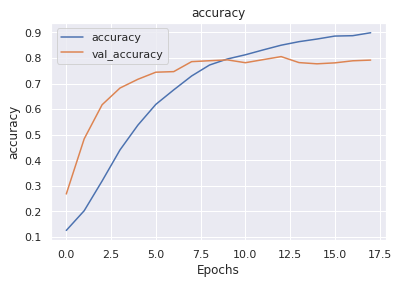

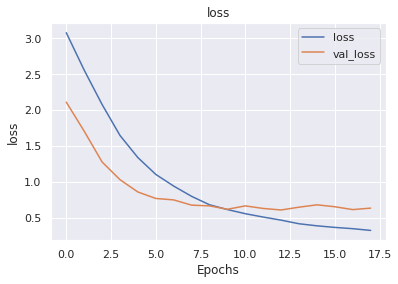

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title(string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
validation_loss, validation_acc = model_cnn_VGG16_da.evaluate(X_test, y_test, verbose = 1)

151/151 [==============================] - 3s 23ms/step - loss: 0.6342 - accuracy: 0.7917


# Transfer Learning VGG19 con Data Augmentation

In [31]:
model_VGG19 =  tf.keras.applications.VGG19(include_top=False,input_shape=(128,128,3), weights='imagenet')
model_VGG19.trainable = True
print("Total layers of VGG19: ", len(model_VGG19.layers))

80142336/80134624 [==============================] - 1s 0us/step
Total layers of VGG19:  22


In [ ]:
for layer in model_VGG19.layers[:12]:
  layer.trainable =  False

model_VGG19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [ ]:
model_cnn_VGG19 = tf.keras.models.Sequential([
    model_VGG19,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64 , activation = 'relu',kernel_initializer='he_uniform', bias_initializer='he_uniform'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_cnn_VGG19.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                524352    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                650       
Total params: 20,549,386
Trainable params: 18,223,818
Non-trainable params: 2,325,568
_________________________________________________________________


In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('Models/model_VGG19_2.hdf5', verbose=1, save_best_only=True)
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [ ]:
learning_rate= 0.0005
opt = tf.keras.optimizers.SGD(learning_rate)
model_cnn_VGG19.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_cnn_VGG19.fit(training,  steps_per_epoch = len(X_train)/128, callbacks=[checkpointer, earlystopper], epochs = 20, verbose=1,validation_data=(X_test, y_test))

Epoch 1/20
137/137 [==============================] - 73s 522ms/step - loss: 2.5154 - accuracy: 0.1113 - val_loss: 2.2559 - val_accuracy: 0.1651

Epoch 00001: val_loss improved from inf to 2.25587, saving model to Models/model_VGG19_2.hdf5
Epoch 2/20
137/137 [==============================] - 72s 523ms/step - loss: 2.3210 - accuracy: 0.1276 - val_loss: 2.2209 - val_accuracy: 0.2265

Epoch 00002: val_loss improved from 2.25587 to 2.22090, saving model to Models/model_VGG19_2.hdf5
Epoch 3/20
137/137 [==============================] - 72s 524ms/step - loss: 2.2525 - accuracy: 0.1614 - val_loss: 2.1275 - val_accuracy: 0.3324

Epoch 00003: val_loss improved from 2.22090 to 2.12753, saving model to Models/model_VGG19_2.hdf5
Epoch 4/20
137/137 [==============================] - 72s 523ms/step - loss: 2.1380 - accuracy: 0.2297 - val_loss: 1.8763 - val_accuracy: 0.4446

Epoch 00004: val_loss improved from 2.12753 to 1.87629, saving model to Models/model_VGG19_2.hdf5
Epoch 5/20
137/137 [========

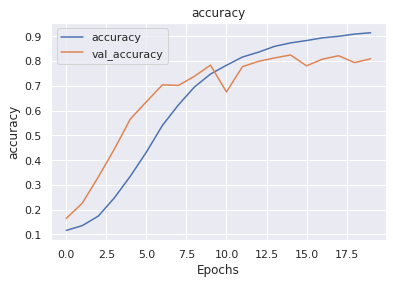

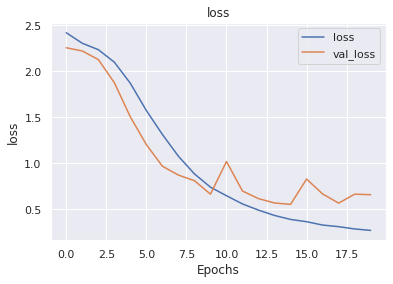

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title(string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
validation_loss, validation_acc = model_cnn_VGG19.evaluate(X_test, y_test, verbose = 1)

151/151 [==============================] - 4s 27ms/step - loss: 0.6598 - accuracy: 0.8094


# Transfer Learning InceptionV3 con Data Augmentation

In [117]:
model_InceptionV3 =  tf.keras.applications.InceptionV3(include_top=False,input_shape=(128,128,3), weights='imagenet')
model_InceptionV3.trainable = True
print("Total layers of InceptionV3: ", len(model_InceptionV3.layers))

Total layers of InceptionV3:  311


In [118]:
for layer in model_InceptionV3.layers[:100]:
 layer.trainable =  False

model_InceptionV3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_658 (Conv2D)             (None, 63, 63, 32)   864         input_18[0][0]                   
__________________________________________________________________________________________________
batch_normalization_658 (BatchN (None, 63, 63, 32)   96          conv2d_658[0][0]                 
__________________________________________________________________________________________________
activation_658 (Activation)     (None, 63, 63, 32)   0           batch_normalization_658[0][0]    
_______________________________________________________________________________________

In [119]:
model_cnn_InceptionV3 = tf.keras.models.Sequential([
    model_InceptionV3,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_cnn_InceptionV3.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
flatten_18 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 10)                81930     
Total params: 21,884,714
Trainable params: 21,338,394
Non-trainable params: 546,320
_________________________________________________________________


In [120]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('Models/model_InceptionV3.hdf5', verbose=1, save_best_only=True)
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [ ]:
learning_rate= 0.0001
opt = tf.keras.optimizers.SGD(learning_rate)
model_cnn_InceptionV3.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_cnn_InceptionV3.fit(training,  steps_per_epoch = len(X_train)/128, callbacks=[checkpointer, earlystopper], epochs = 20, verbose=1,validation_data=(X_test, y_test))

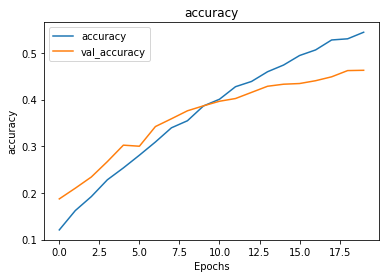

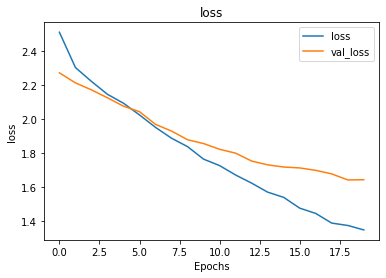

In [87]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title(string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")